In [18]:
# Import our dependencies
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import resample
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path
import hvplot.pandas
import psycopg2
import config
from config import db_pw

In [2]:
#establishing the connection
conn = psycopg2.connect(
   database="Predictive_Senescence_DB", user='postgres', password= db_pw, host='predictive-senescence-db.cbunnafql9ym.us-east-2.rds.amazonaws.com', port= '5432'
)

#Setting auto commit false
conn.autocommit = True

#Creating a cursor object using the cursor() method
cursor = conn.cursor()

#Retrieving data
cursor.execute('''SELECT * from birds_data_raw''')

#Fetching 1st row from the table
df = pd.DataFrame(cursor.fetchall(), columns=["Collection_Num", "BirdID", "Sex", "AgeY", "AgeClass", "BirthFPID", "U_PlateID", "RTL", "Technician", "Terr", "FPID", 'mum', 'dad', "MAC", 'PAC','BrF', 'BrM']);
print(df)

#Commit your changes in the database
conn.commit()

#Closing the connection
conn.close()

      Collection_Num  BirdID  Sex       AgeY AgeClass  BirthFPID U_PlateID  \
0                  1    5511    0   0.246575        J        103       9_3   
1                  2    5559    1   3.597260        A        103       9_1   
2                  3    5559    1   4.715068        A        103      9_28   
3                  4    5559    1   0.657534       SA        103       9_2   
4                  5    5527    1   0.328767      OFL        103       9_3   
...              ...     ...  ...        ...      ...        ...       ...   
2657            2658     221    1   6.958904        A          8       2_1   
2658            2659     216    1   8.947945        A          8       8_8   
2659            2660     176    1   6.772603        A          8      7_32   
2660            2661     221    1   9.090411        A          8      1_12   
2661            2662     176    1  13.873973        A          8       4_3   

       RTL  Technician   Terr  FPID   mum   dad       MAC      

In [3]:
# Generate our categorical variable list
df_cat = df.dtypes[df.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
df[df_cat].nunique()

AgeClass       6
U_PlateID    271
dtype: int64

In [4]:
# Check the unique value counts to see if binning is required
df.AgeY.value_counts()

0.657534    212
0.328767    162
0.164384    144
1.000000     96
0.027397     87
           ... 
2.010959      1
3.323288      1
3.386301      1
6.909589      1
7.041096      1
Name: AgeY, Length: 1262, dtype: int64

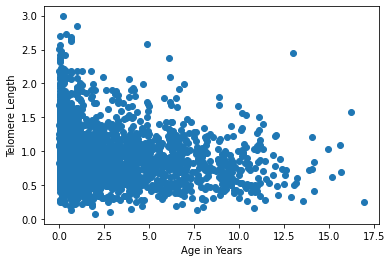

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.scatter(df.AgeY, df.RTL)
plt.xlabel('Age in Years')
plt.ylabel('Telomere Length')
plt.show()
#fig.savefig('ScattAgeTelo.png')


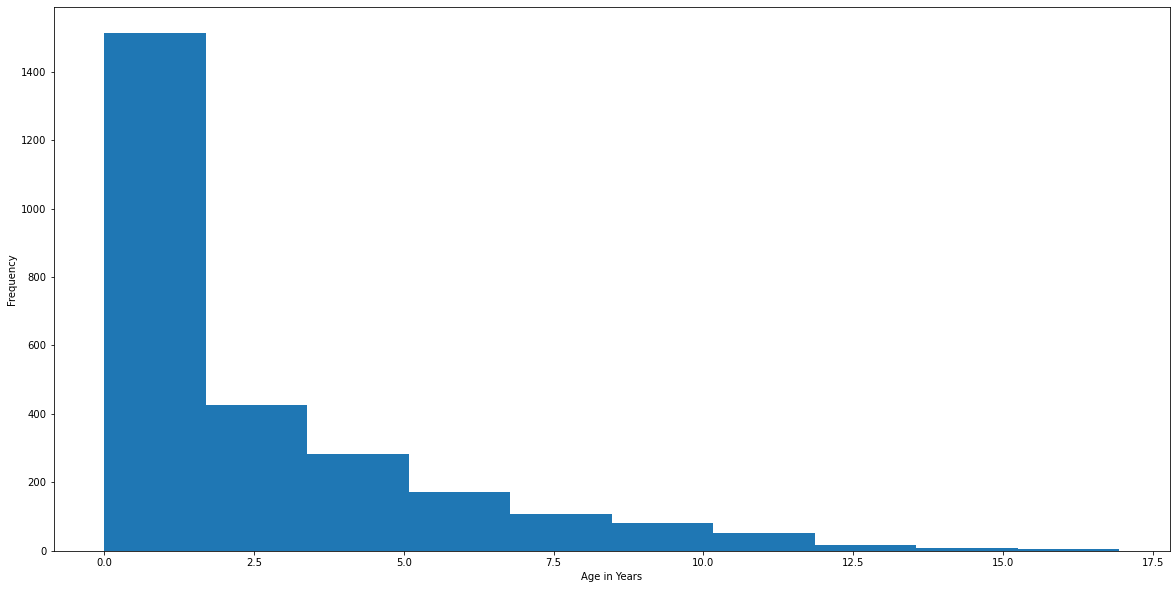

In [6]:
fig = plt.figure(figsize=(20,10))
plt.hist(df.AgeY)
plt.xlabel('Age in Years')
plt.ylabel('Frequency')
plt.show()
#fig.savefig('HistAgeY.png')

In [7]:
# add Age_CAt to the sub_df dataframe
# https://www.youtube.com/watch?v=to5xBubdcqo

df['AgeClass']= df['AgeClass'].replace({"FL":"CH"})
df['AgeClass']= df['AgeClass'].replace({"OFL":"J"})
df['AgeClass']= df['AgeClass'].replace({"SA":"A"})
df['AgeClass'].value_counts()
df.head()

,Collection_Num,BirdID,Sex,AgeY,AgeClass,BirthFPID,U_PlateID,RTL,Technician,Terr,FPID,mum,dad,MAC,PAC,BrF,BrM
0,1,5511,0,0.246575,J,103,9_3,1.06,1,10.0,104,4863,1762,3.920548,7.443836,4863,1762
1,2,5559,1,3.597260,A,103,9_1,0.52,1,77.1,122,1716,1877,7.416438,6.235616,1716,4892
2,3,5559,1,4.715068,A,103,9_28,1.07,1,77.1,125,1716,1877,7.416438,6.235616,1716,4892
3,4,5559,1,0.657534,A,103,9_2,0.99,1,111.0,104,1716,1877,7.416438,6.235616,1716,4892
4,5,5527,1,0.328767,J,103,9_3,1.02,1,131.0,104,4936,1710,3.452055,7.778082,1707,1710


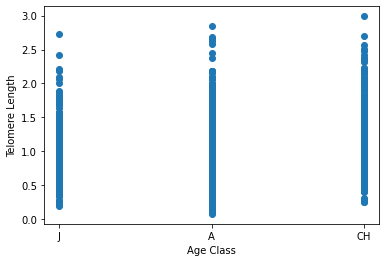

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.scatter(df.AgeClass, df.RTL)
plt.xlabel('Age Class')
plt.ylabel('Telomere Length')
plt.show()
#fig.savefig('ScattFourClass.png')

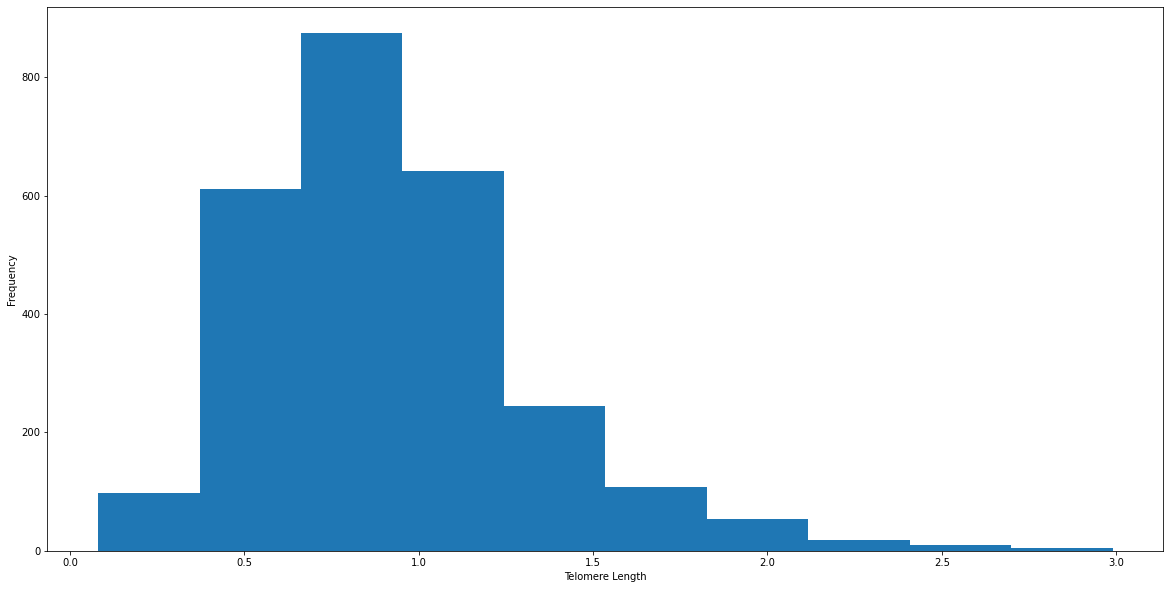

In [9]:
fig = plt.figure(figsize=(20,10))
plt.hist(df.RTL)
plt.xlabel('Telomere Length')
plt.ylabel('Frequency')
plt.show()
#fig.savefig('HistTelo.png')


<AxesSubplot:title={'center':'RTL'}, xlabel='[AgeClass]'>

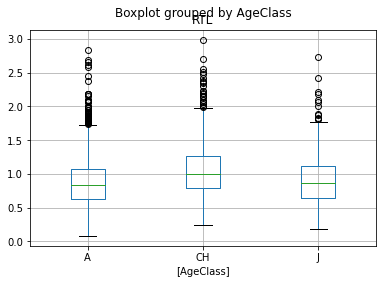

In [10]:
from matplotlib import pyplot as plt
# Plot boxplots of RTL by AgeClass
df.boxplot(['RTL'], by=['AgeClass'])
#plt.savefig('ThreeClass.png')

In [24]:
# Remove AgeClass status target from features data
y = df.AgeClass
X = df.drop(columns=["Collection_Num","BirdID", "Sex","AgeY", "AgeClass","BirthFPID","U_PlateID", "Technician", "Terr", "FPID", "mum", "dad", "MAC", "PAC", "BrF", "BrM"])

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [12]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.670


In [13]:
rf_model = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)
print(f'Training Score: {rf_model.score(X_train_scaled, y_train)}')
print(f'Testing Score: {rf_model.score(X_test_scaled, y_test)}')

Training Score: 0.7099198396793587
Testing Score: 0.6681681681681682


#### Random Forest is able to predict age class from telomere length approximaetly 67% of the time accurately. 